# PINN pour un circuit RC-AC avec une perte physique 
### Decomment 2nd block of code for consistent initialising seed
### Network trained with dataset used ***without DataLoader***

<u>Import nécessaire :</u>

In [ ]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import csv 
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
import random
import joblib

In [89]:
# Initialise random seed for model weights and activations

def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # If using torch.backends (optional for CPU, more relevant for CUDA)
    if torch.backends.mps.is_available():
        torch.use_deterministic_algorithms(True)

set_seed(42)

In [90]:
# A  COMPLETER AVEC LE NOM DU FICHIER CSV
df = pd.read_csv( "rc_ac_results_12500L.csv" )
#print(df)
print( df.shape )

(75125, 12)


In [91]:

# Data normalisation
X = df[ [ "R" , "C" , "Vin" , "Frequency" ] ].values
Y = df[ [ "Gain_basse", "Gain_haute" , "Phase_R" , "Phase_C" ] ].values
Y_GB = df[ [ "Gain_basse" ] ].values
Y_GH = df[ [ "Gain_haute" ] ].values
Y_PR = df[ [ "Phase_R" ] ].values
Y_PC = df[ [ "Phase_C" ] ].values


scaler_x = StandardScaler()

scaler_y = StandardScaler()

scaler_y_GB = StandardScaler()
scaler_y_GH = StandardScaler()
scaler_y_PR = StandardScaler()
scaler_y_PC = StandardScaler()

X_tensor = torch.tensor( scaler_x.fit_transform(X) , dtype = torch.float32 )

#######
Y_tensor = torch.tensor( scaler_y.fit_transform(Y) , dtype = torch.float32 )
#######

Y_tensor_GB = torch.tensor( scaler_y_GB.fit_transform(Y_GB) , dtype = torch.float32 )
Y_tensor_GH = torch.tensor( scaler_y_GH.fit_transform(Y_GH) , dtype = torch.float32 )
Y_tensor_PR = torch.tensor( scaler_y_PR.fit_transform(Y_PR) , dtype = torch.float32 )
Y_tensor_PC = torch.tensor( scaler_y_PC.fit_transform(Y_PC) , dtype = torch.float32 )

#print(X_tensor[:,0])
#print(Y_tensor)

dataset = TensorDataset( X_tensor , Y_tensor )

dataset_GB = TensorDataset( X_tensor , Y_tensor_GB )
dataset_GH = TensorDataset( X_tensor , Y_tensor_GH )
dataset_PR = TensorDataset( X_tensor , Y_tensor_PR )
dataset_PC = TensorDataset( X_tensor , Y_tensor_PC )

loader = DataLoader(dataset, batch_size=256, shuffle=True)

R = X_tensor[ :,0 ]
C = X_tensor[ :,1 ]
Frequency = X_tensor[ :,3 ]
print( R )
print( C )

print( ( R*C ).shape )

tensor([-1.0196, -1.0196, -1.0196,  ...,  1.7504,  1.7504,  1.7504])
tensor([-0.7601, -0.7601, -0.7601,  ...,  1.9125,  1.9125,  1.9125])
torch.Size([75125])


In [92]:
class RegressionModel(nn.Module):
    def __init__( self , in_features , out_features = 4 ):
        super().__init__()

        """"
        nn.Linear( a , b ) crée une couche fully connected

            a : neurones en input
            b : neurones en output
        """
        self.fc1 = nn.Linear( in_features , 64 )
        self.fc2 = nn.Linear( 64 , 64 )
        self.fc3 = nn.Linear( 64 , 64 )
        self.fc4 = nn.Linear( 64 , 64 )
        self.fc5 = nn.Linear( 64 , 64 )
        self.fc6 = nn.Linear( 64 , out_features )
        


    def forward( self , x ):
        x = F.tanh( self.fc1( x ) )
        x = F.tanh( self.fc2( x ) )
        x = F.tanh( self.fc3( x ) )
        x = F.tanh( self.fc4( x ) )
        x = F.tanh( self.fc5( x ) )
        x = self.fc6( x )  # No activation on output for regression
        return x

In [93]:
in_features = 4
out_features = 4


model = RegressionModel( in_features , out_features )

criterion = nn.MSELoss()
optimizer = optim.Adam( model.parameters() , lr = 0.001 )


In [94]:
# Function to compute the PDE residual pour gain basse : 
""""
def pde_residual( model , x , out ):
    # Make sure x is set to require gradients for derivative calculations.
    x = x.clone().detach().requires_grad_( True )
    u = model( x ).squeeze( )
    
    #t = x[ :, 0]
    # Compute the first derivative, du/dt.
    #u_x = ( torch.autograd.grad( u , t , grad_outputs = torch.ones_like(u) , create_graph = True )[ 0 ] )[ :,0 ]
    
    #print( u_x.shape )
    #print( x.shape )
    #print( u[:,0].shape )

    R = x[ :, 0 ]
    C = x[ :, 1 ]
    Vin = x[ :, 2 ]
    Frequency = x[ :, 3 ]
    w = 2 * torch.pi * Frequency

    # Sorties du modèle
    gain_basse_1 = u[ :, 0 ]
    gain_haute_1 = u[ :, 1 ]
    phase_R_1 = u[ :, 2 ]
    phase_C_1 = u[ :, 3 ]

    
    # Gain basse fréquence : 1 / sqrt(1 + (wRC)^2)
    gain_basse_th = 1 / torch.sqrt(1 + (w * R * C) ** 2)

    # Gain haute fréquence : 1 / sqrt(1 + (wRC)^2)
    gain_haute_th = 1 / torch.sqrt( 1 + ( w * R * C ) ** 2 )

    # Phase de R : arctan( wRC ) vers pi / 2
    phase_R_th = torch.atan( w * R * C )

    # Phase de C : -arctan(wRC) vers -pi / 2
    phase_C_th = - torch.atan( w * R * C )

    # Calculs des résidus
    res_gain_basse = ( gain_basse_1 - gain_basse_th ) ** 2
    res_gain_haute = ( gain_haute_1 - gain_haute_th ) ** 2
    res_phase_R = ( phase_R_1 - phase_R_th ) ** 2
    res_phase_C = ( phase_C_1 - phase_C_th ) ** 2

    #residual = res_gain_basse + res_gain_haute + res_phase_R + res_phase_C
    if out == "Gain_basse":
        residual = res_gain_basse
    elif out == "Gain_haute":
        residual = res_gain_haute
    elif out == "Phase_R":
        residual = res_phase_R
    elif out == "Phase_C":     
        residual = res_phase_C
    else:   
        print("Erreur : la sortie demandée n'est pas valide.")
        residual = None
    return torch.mean( residual )
"""

def pde_residual(model, x, out):
    x = x.clone().detach().requires_grad_(True)
    u = model(x)

    R = x[:, 0]
    C = x[:, 1]
    Vin = x[:, 2]
    Frequency = x[:, 3]
    w = 2 * torch.pi * Frequency

    # Calcul de la cible physique selon le nom de sortie
    if out == "Gain_basse":
        u_model = u[:, 0]
        u_phys = 1 / torch.sqrt(1 + (w * R * C) ** 2)
    elif out == "Gain_haute":
        u_model = u[:, 1]
        u_phys = 1 / torch.sqrt(1 + (w * R * C) ** 2)
    elif out == "Phase_R":
        u_model = u[:, 2]
        u_phys = torch.atan(w * R * C)
    elif out == "Phase_C":
        u_model = u[:, 3]
        u_phys = -torch.atan(w * R * C)
    else:
        raise ValueError("Sortie non valide.")

    residual = (u_model - u_phys) ** 2
    return torch.mean(residual)


#pde_test = pde_residual(model, X_tensor)
#print(pde_test)
#print(pde_test.shape)



Epoch [1], Loss: 1.035235047
Epoch [1], Loss: 1.030169129
Epoch [1], Loss: 1.117077470
Epoch [1], Loss: 1.101281166

Epoch [1], Loss: 1.035336733
Epoch [1], Loss: 1.082064748
Epoch [1], Loss: 1.133159280
Epoch [1], Loss: 1.116009355

Epoch [1], Loss: 1.025970101
Epoch [1], Loss: 1.084527731
Epoch [1], Loss: 1.143651009
Epoch [1], Loss: 1.104347348

Epoch [1], Loss: 1.011071920
Epoch [1], Loss: 1.066498280
Epoch [1], Loss: 1.131999969
Epoch [1], Loss: 1.075429201

Epoch [1], Loss: 0.953895330
Epoch [1], Loss: 1.035415292
Epoch [1], Loss: 1.090537906
Epoch [1], Loss: 1.016006231

Epoch [1], Loss: 0.928451478
Epoch [1], Loss: 1.014899492
Epoch [1], Loss: 1.061300635
Epoch [1], Loss: 0.983110726

Epoch [1], Loss: 0.939726830
Epoch [1], Loss: 1.015507102
Epoch [1], Loss: 1.085952282
Epoch [1], Loss: 0.985262215

Epoch [1], Loss: 0.899879038
Epoch [1], Loss: 1.021564603
Epoch [1], Loss: 1.020993233
Epoch [1], Loss: 0.964779735

Epoch [1], Loss: 0.879413486
Epoch [1], Loss: 0.958794713
Epoch 

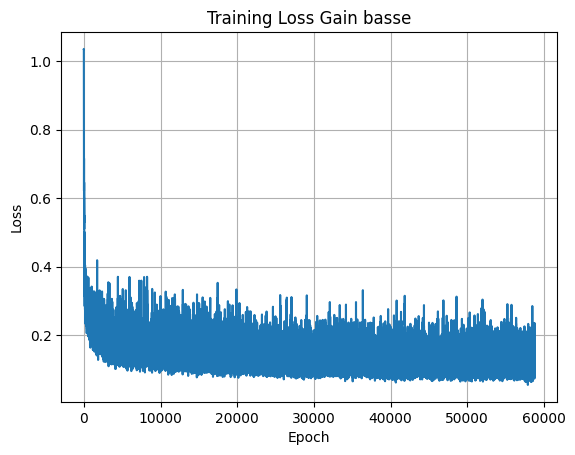

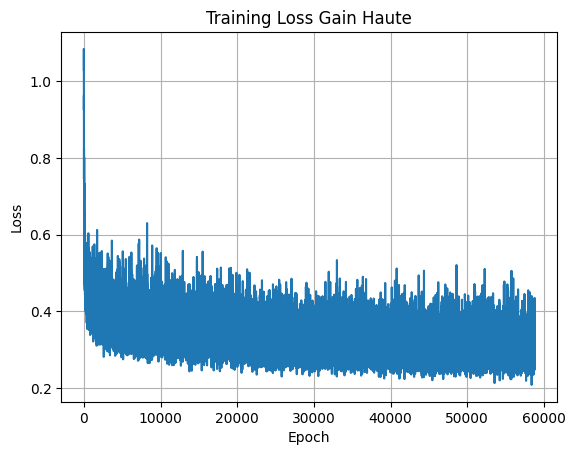

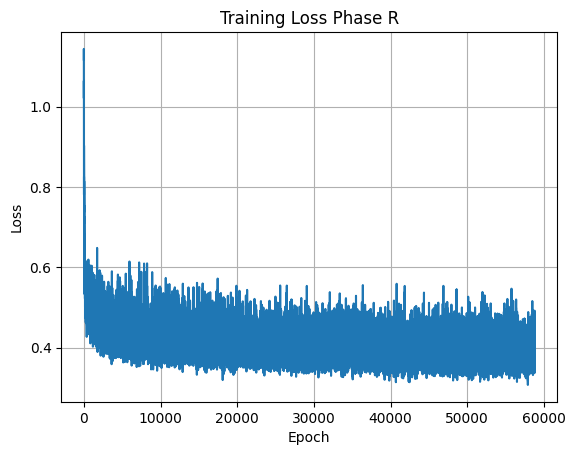

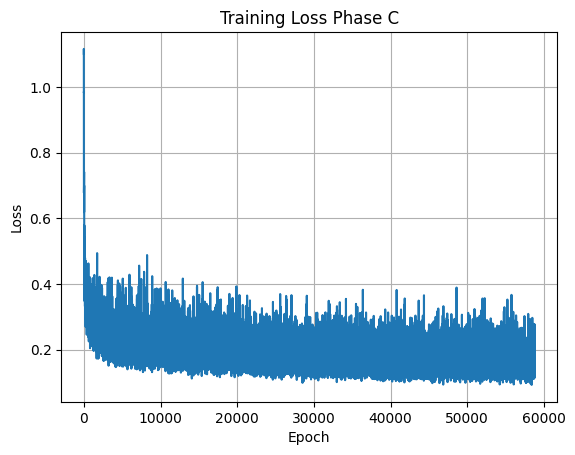

In [95]:
nb_epochs = 200
losses_GH = []
losses_GB = []
losses_PR = []
losses_PC = []
# Before training
#set_seed(42)
model.train()
ld = 0.1
for i in range(nb_epochs):
    
    for X_batch, Y_batch in loader:
        
        outputs = model(X_batch)
        X_batch_denorm = torch.tensor(
            scaler_x.inverse_transform(X_batch.detach().cpu().numpy()), 
            dtype=torch.float32
        )

        R = X_batch_denorm[:, 0]
        C = X_batch_denorm[:, 1]
        Frequency = X_batch_denorm[:, 3]
        w = 2 * torch.pi * Frequency

        # Physics loss (avec .detach() sur outputs)
        #R = X_batch[:, 0]
        #C = X_batch[:, 1]
        #Frequency = X_batch[:, 3]
        #w = 2 * torch.pi * Frequency

        gain_basse_th = 1 / torch.sqrt(1 + (w * R * C) ** 2)
        gain_haute_th = 1 / torch.sqrt(1 + (w * R * C) ** 2)
        phase_R_th = torch.atan(w * R * C)
        phase_C_th = -torch.atan(w * R * C)

        loss_physics_GB = ((outputs[:, 0] - gain_basse_th) ** 2).mean()
        loss_physics_GH = ((outputs[:, 1] - gain_haute_th) ** 2).mean()
        loss_physics_PR = ((outputs[:, 2] - phase_R_th) ** 2).mean()
        loss_physics_PC = ((outputs[:, 3] - phase_C_th) ** 2).mean()

        # MSE loss
        loss_mse_GB = criterion(outputs[:, 0:1], Y_batch[:, 0:1])
        loss_mse_GH = criterion(outputs[:, 1:2], Y_batch[:, 1:2])
        loss_mse_PR = criterion(outputs[:, 2:3], Y_batch[:, 2:3])
        loss_mse_PC = criterion(outputs[:, 3:4], Y_batch[:, 3:4])

        # Total loss par sortie
        loss_GB = loss_mse_GB + ld * loss_physics_GB
        loss_GH = loss_mse_GH + ld * loss_physics_GH
        loss_PR = loss_mse_PR + ld * loss_physics_PR
        loss_PC = loss_mse_PC + ld * loss_physics_PC

        # Backward
        total_loss = loss_GB + loss_GH + loss_PR + loss_PC

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Logging
        losses_GB.append(loss_GB.item())
        losses_GH.append(loss_GH.item())
        losses_PR.append(loss_PR.item())
        losses_PC.append(loss_PC.item())

        if ( i % 25 == 0 ):
            print(f'Epoch [{i+1}], Loss: {loss_GB.item():.9f}')
            print(f'Epoch [{i+1}], Loss: {loss_GH.item():.9f}')
            print(f'Epoch [{i+1}], Loss: {loss_PR.item():.9f}')
            print(f'Epoch [{i+1}], Loss: {loss_PC.item():.9f}')
            print()

# Courbes de perte
plt.plot(losses_GB, label='Gain basse')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Gain basse')
plt.grid(True)
plt.show()

plt.plot(losses_GH, label='Gain Haute')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Gain Haute')
plt.grid(True)
plt.show()

plt.plot(losses_PR, label='Phase R')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Phase R')
plt.grid(True)
plt.show()

plt.plot(losses_PC, label='Phase C')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Phase C')
plt.grid(True)
plt.show()


Loss GB : 0.076
Loss GH : 0.188
Loss PR : 0.128
Loss PC : 0.127


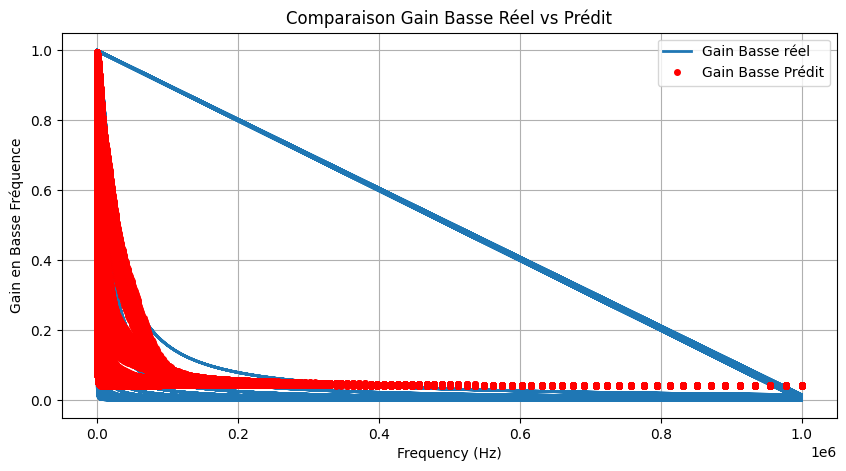

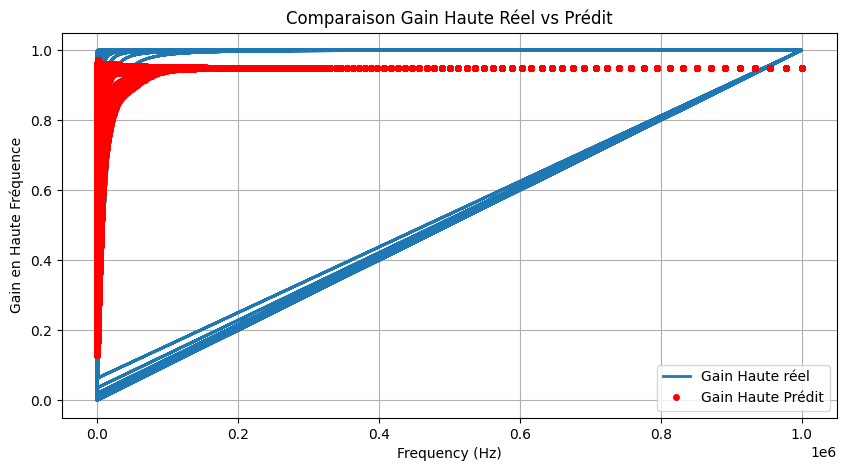

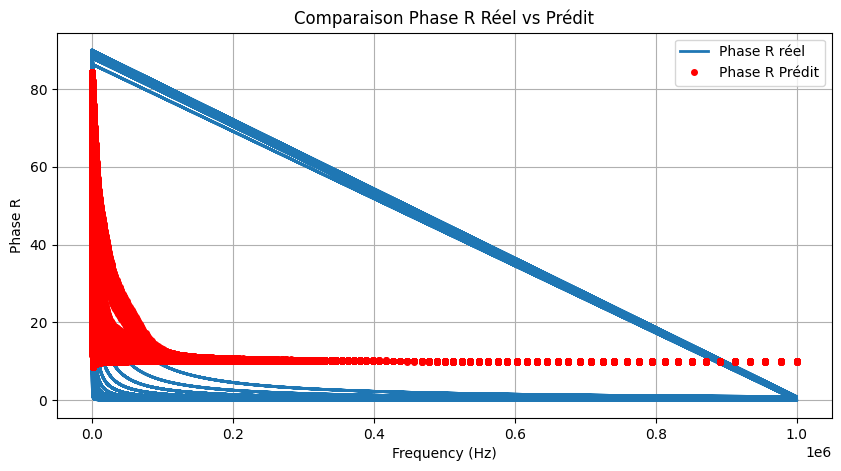

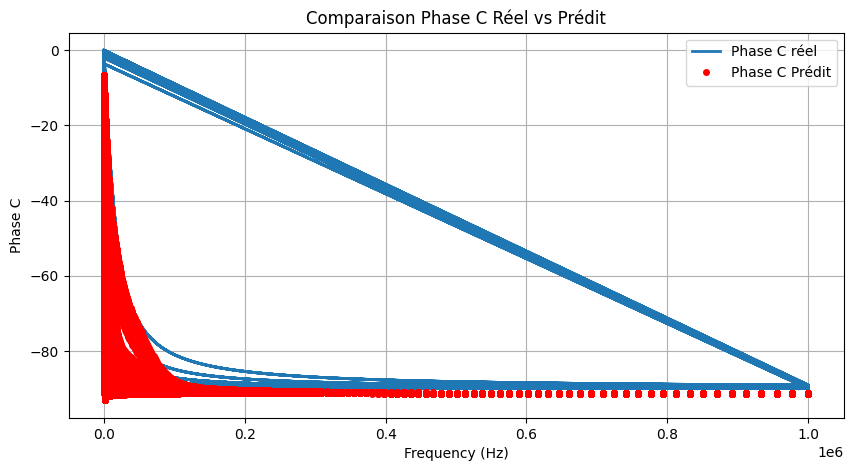

In [96]:
model.eval()

with torch.no_grad():
    # Prédictions (N, 4)
    predictions = model(X_tensor).cpu().numpy()

    # Séparation des colonnes
    predictions_GB = predictions[:, 0:1]
    predictions_GH = predictions[:, 1:2]
    predictions_PR = predictions[:, 2:3]
    predictions_PC = predictions[:, 3:4]

    # Calcul des pertes
    loss_GB = criterion(torch.tensor(predictions_GB), Y_tensor_GB)
    loss_GH = criterion(torch.tensor(predictions_GH), Y_tensor_GH)
    loss_PR = criterion(torch.tensor(predictions_PR), Y_tensor_PR)
    loss_PC = criterion(torch.tensor(predictions_PC), Y_tensor_PC)

    print(f"Loss GB : {loss_GB.item():.3f}")
    print(f"Loss GH : {loss_GH.item():.3f}")
    print(f"Loss PR : {loss_PR.item():.3f}")
    print(f"Loss PC : {loss_PC.item():.3f}")

    # Dénormalisation des prédictions
    predictions_original_GB = scaler_y_GB.inverse_transform(predictions_GB)
    predictions_original_GH = scaler_y_GH.inverse_transform(predictions_GH)
    predictions_original_PR = scaler_y_PR.inverse_transform(predictions_PR)
    predictions_original_PC = scaler_y_PC.inverse_transform(predictions_PC)

    # Dénormalisation des vraies valeurs
    Y_true_original_GB = scaler_y_GB.inverse_transform(Y_tensor_GB.numpy())
    Y_true_original_GH = scaler_y_GH.inverse_transform(Y_tensor_GH.numpy())
    Y_true_original_PR = scaler_y_PR.inverse_transform(Y_tensor_PR.numpy())
    Y_true_original_PC = scaler_y_PC.inverse_transform(Y_tensor_PC.numpy())

    # Dénormalisation des fréquences
    frequencies = scaler_x.inverse_transform(X_tensor.numpy())[:, 3]

# Tracé Gain Basse
plt.figure(figsize=(10, 5))
plt.plot(frequencies, Y_true_original_GB[:, 0], label="Gain Basse réel", linewidth=2)
plt.plot(frequencies, predictions_original_GB[:, 0], 'o', label="Gain Basse Prédit", markersize=4, color='red')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Gain en Basse Fréquence")
plt.title("Comparaison Gain Basse Réel vs Prédit")
plt.legend()
plt.grid(True)
plt.show()

# Tracé Gain Haute
plt.figure(figsize=(10, 5))
plt.plot(frequencies, Y_true_original_GH[:, 0], label="Gain Haute réel", linewidth=2)
plt.plot(frequencies, predictions_original_GH[:, 0], 'o', label="Gain Haute Prédit", markersize=4, color='red')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Gain en Haute Fréquence")
plt.title("Comparaison Gain Haute Réel vs Prédit")
plt.legend()
plt.grid(True)
plt.show()

# Tracé Phase R
plt.figure(figsize=(10, 5))
plt.plot(frequencies, Y_true_original_PR[:, 0], label="Phase R réel", linewidth=2)
plt.plot(frequencies, predictions_original_PR[:, 0], 'o', label="Phase R Prédit", markersize=4, color='red')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase R")
plt.title("Comparaison Phase R Réel vs Prédit")
plt.legend()
plt.grid(True)
plt.show()

# Tracé Phase C
plt.figure(figsize=(10, 5))
plt.plot(frequencies, Y_true_original_PC[:, 0], label="Phase C réel", linewidth=2)
plt.plot(frequencies, predictions_original_PC[:, 0], 'o', label="Phase C Prédit", markersize=4, color='red')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase C")
plt.title("Comparaison Phase C Réel vs Prédit")
plt.legend()
plt.grid(True)
plt.show()

In [97]:
# Print model's state_dict
print( "Model's state_dict:" )
for param_tensor in model.state_dict():
    print( param_tensor, "\t", model.state_dict()[ param_tensor ].size() )

# Print optimizer's state_dict
"""print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])"""



Model's state_dict:
fc1.weight 	 torch.Size([64, 4])
fc1.bias 	 torch.Size([64])
fc2.weight 	 torch.Size([64, 64])
fc2.bias 	 torch.Size([64])
fc3.weight 	 torch.Size([64, 64])
fc3.bias 	 torch.Size([64])
fc4.weight 	 torch.Size([64, 64])
fc4.bias 	 torch.Size([64])
fc5.weight 	 torch.Size([64, 64])
fc5.bias 	 torch.Size([64])
fc6.weight 	 torch.Size([4, 64])
fc6.bias 	 torch.Size([4])


'print("Optimizer\'s state_dict:")\nfor var_name in optimizer.state_dict():\n    print(var_name, "\t", optimizer.state_dict()[var_name])'

In [105]:
 # Defining model name and save the model

name = "My_model"    # À changer selon l'utilisateur
#torch.save( model.state_dict() , name )

torch.save(model.state_dict(), "pinn_RC_AC_transient.pt")
joblib.dump(scaler_x, "pinn_RC_AC_transient_scaler_X.pkl")
joblib.dump(scaler_y, "pinn_RC_AC_transient_scaler_y.pkl")

# Load the saved model and evaluate

my_model = RegressionModel( in_features , out_features )
my_model.load_state_dict( torch.load( name , weights_only = True ) )
my_model.eval()

# net_pinn.load_state_dict(torch.load("pinn_rc_transient.pt"))
# net_pinn.scaler_X = joblib.load("pinn_rc_transient_scaler_X.pkl")
# net_pinn.scaler_y = joblib.load("pinn_rc_transient_scaler_y.pkl")

with torch.no_grad():
    # Forward pass
    predictions = my_model( X_tensor )  

    # Calculate the loss (optional)
    lossgh = criterion( predictions , Y_tensor_GH )
    lossgb = criterion( predictions , Y_tensor_GB )
    losspr = criterion( predictions , Y_tensor_PR )
    losspc = criterion( predictions , Y_tensor_PC )
    #print( f"Evaluation Loss: {loss.item():.3f}" )

    print(f"Evaluation Loss GB after loading: {lossgb.item():.5f}")
    print(f"Evaluation Loss GH after loading: {lossgh.item():.5f}")
    print(f"Evaluation Loss PR after loading: {losspr.item():.5f}")
    print(f"Evaluation Loss PC after loading: {losspc.item():.5f}")
    #print(f"Epoch {i+1}: total={loss.item():.5f}, mse={loss_mse.item():.5f}, phys={loss_physics.item():.5f}")


Evaluation Loss GB after loading: 0.80929
Evaluation Loss GH after loading: 2.49063
Evaluation Loss PR after loading: 0.81680
Evaluation Loss PC after loading: 0.81680


/home/abdel-kader/venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([75125, 1])) that is different to the input size (torch.Size([75125, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


<u>Trier les données par fréquence et moyenner les prédictions pour chaque fréquence </u>

GB

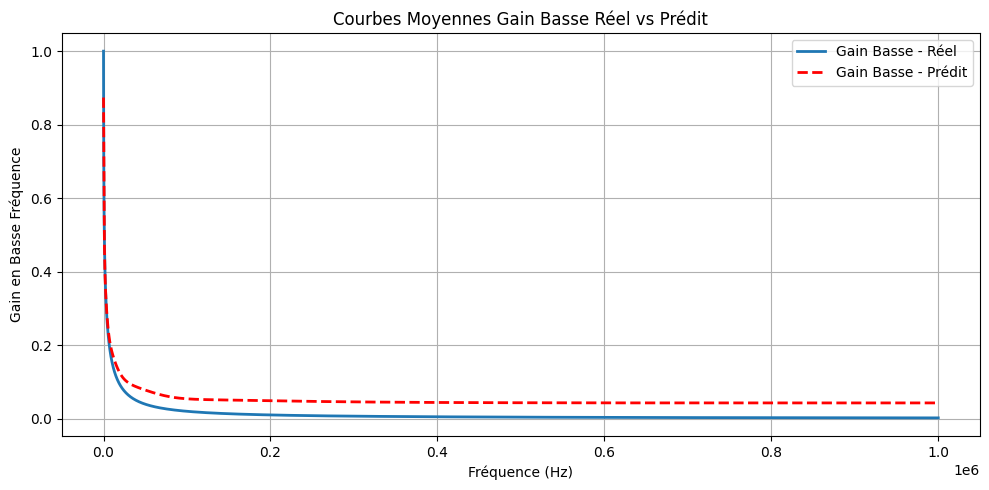

In [100]:
import pandas as pd

# Récupération des fréquences dénormalisées et des valeurs (réelles et prédites)
frequencies = scaler_x.inverse_transform(X_tensor.numpy())[:, 3]
gain_basse_true = Y_true_original_GB[:, 0]
gain_basse_pred = predictions_original_GB[:, 0]

# Créer un DataFrame pour regrouper et moyenner par fréquence
df_plot = pd.DataFrame({
    "Frequency": frequencies,
    "Gain_basse_true": gain_basse_true,
    "Gain_basse_pred": gain_basse_pred
})

# Regroupement par fréquence (moyenne pour chaque fréquence)
df_mean = df_plot.groupby("Frequency").mean().reset_index()

# Affichage de la courbe unique
plt.figure(figsize=(10, 5))
plt.plot(df_mean["Frequency"], df_mean["Gain_basse_true"], label="Gain Basse - Réel", linewidth=2)
plt.plot(df_mean["Frequency"], df_mean["Gain_basse_pred"], label="Gain Basse - Prédit", linewidth=2, linestyle='--', color='red')

plt.xlabel("Fréquence (Hz)")
plt.ylabel("Gain en Basse Fréquence")
plt.title("Courbes Moyennes Gain Basse Réel vs Prédit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


GH

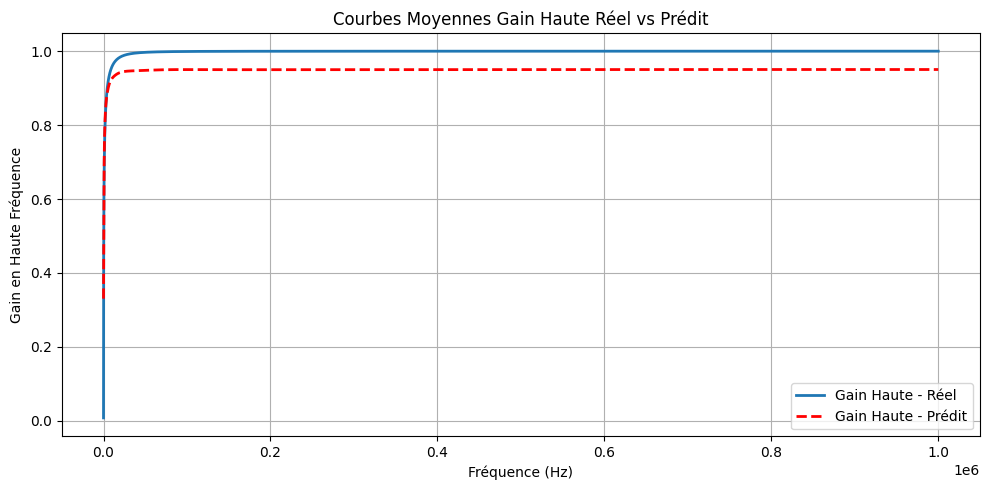

In [101]:
import pandas as pd

# Récupération des fréquences dénormalisées et des valeurs (réelles et prédites)
frequencies = scaler_x.inverse_transform(X_tensor.numpy())[:, 3]
gain_haute_true = Y_true_original_GH[:, 0]
gain_haute_pred = predictions_original_GH[:, 0]

# Créer un DataFrame pour regrouper et moyenner par fréquence
df_plot = pd.DataFrame({
    "Frequency": frequencies,
    "Gain_haute_true": gain_haute_true,
    "Gain_haute_pred": gain_haute_pred
})

# Regroupement par fréquence (moyenne pour chaque fréquence)
df_mean = df_plot.groupby("Frequency").mean().reset_index()

# Affichage de la courbe unique
plt.figure(figsize=(10, 5))
plt.plot(df_mean["Frequency"], df_mean["Gain_haute_true"], label="Gain Haute - Réel", linewidth=2)
plt.plot(df_mean["Frequency"], df_mean["Gain_haute_pred"], label="Gain Haute - Prédit", linewidth=2, linestyle='--', color='red')

plt.xlabel("Fréquence (Hz)")
plt.ylabel("Gain en Haute Fréquence")
plt.title("Courbes Moyennes Gain Haute Réel vs Prédit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


PR

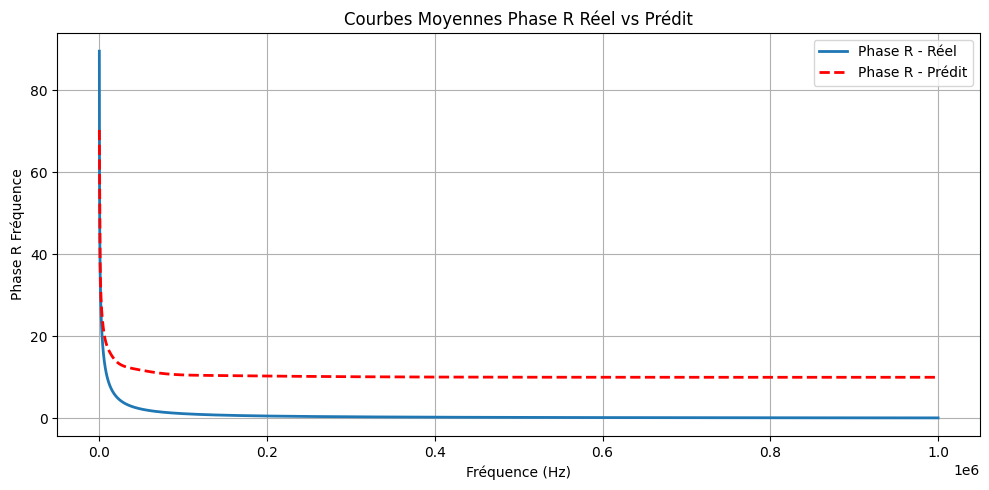

In [102]:
import pandas as pd

# Récupération des fréquences dénormalisées et des valeurs (réelles et prédites)
frequencies = scaler_x.inverse_transform(X_tensor.numpy())[:, 3]
phase_r_true = Y_true_original_PR[:, 0]
phase_r_pred = predictions_original_PR[:, 0]

# Créer un DataFrame pour regrouper et moyenner par fréquence
df_plot = pd.DataFrame({
    "Frequency": frequencies,
    "Phase_r_true": phase_r_true,
    "Phase_r_pred": phase_r_pred
})

# Regroupement par fréquence (moyenne pour chaque fréquence)
df_mean = df_plot.groupby("Frequency").mean().reset_index()

# Affichage de la courbe unique
plt.figure(figsize=(10, 5))
plt.plot(df_mean["Frequency"], df_mean["Phase_r_true"], label="Phase R - Réel", linewidth=2)
plt.plot(df_mean["Frequency"], df_mean["Phase_r_pred"], label="Phase R - Prédit", linewidth=2, linestyle='--', color='red')

plt.xlabel("Fréquence (Hz)")
plt.ylabel("Phase R Fréquence")
plt.title("Courbes Moyennes Phase R Réel vs Prédit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


PC

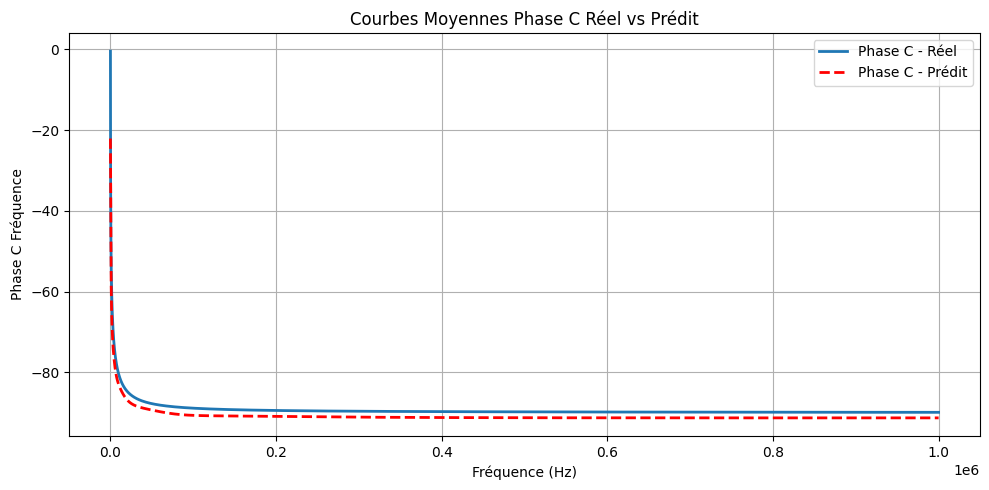

In [103]:
import pandas as pd

# Récupération des fréquences dénormalisées et des valeurs (réelles et prédites)
frequencies = scaler_x.inverse_transform(X_tensor.numpy())[:, 3]
phase_c_true = Y_true_original_PC[:, 0]
phase_c_pred = predictions_original_PC[:, 0]

# Créer un DataFrame pour regrouper et moyenner par fréquence
df_plot = pd.DataFrame({
    "Frequency": frequencies,
    "Phase_c_true": phase_c_true,
    "Phase_c_pred": phase_c_pred
})

# Regroupement par fréquence (moyenne pour chaque fréquence)
df_mean = df_plot.groupby("Frequency").mean().reset_index()

# Affichage de la courbe unique
plt.figure(figsize=(10, 5))
plt.plot(df_mean["Frequency"], df_mean["Phase_c_true"], label="Phase C - Réel", linewidth=2)
plt.plot(df_mean["Frequency"], df_mean["Phase_c_pred"], label="Phase C - Prédit", linewidth=2, linestyle='--', color='red')

plt.xlabel("Fréquence (Hz)")
plt.ylabel("Phase C Fréquence")
plt.title("Courbes Moyennes Phase C Réel vs Prédit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
